# Pseudo arc-length continuation in the CR3BP

In this example we will refine the basic continuation scheme used in [Continuation of Periodic Orbits in the CR3BP](<./Periodic orbits in the CR3BP.ipynb>) and use instead, as continuation parameter, the [pseudo arc-length](https://en.wikipedia.org/wiki/Numerical_continuation#Pseudo-arclength_continuation) to obtain the family of Lyapunov orbits around L1.

The resulting numerical scheme allows to follow through folds of the curve implicitly defined by the periodicity condition and the Poincare' phasing condition.

## Preamble
As usual, we make some standard imports:

In [1]:
import heyoka as hy
import numpy as np
import time 

from scipy.optimize import least_squares, root_scalar
from copy import deepcopy

from initial_exploration_ross import *

from matplotlib.pylab import plt

%matplotlib inline 

... and define some functions that will help later on to visualize our trajectories and make nice plots. (ignore them and come back to this later in case you are curious)

In [2]:
def compute_L_points(mu, cf_px):
    """Computes The exact position of the Lagrangian points. To do so it finds the zeros of the
    the dynamics equation for px.
    
        Args:
            mu (float): The value of the mu parameter.
            cf_px (heyoka compiled function): The px dynamics equation. (will only depend on x,y,z,py)

        Returns:
            xL1, xL2, xL3, xL45, yL45: The coordinates of the various Lagrangian Points
    """
    # Position of the lagrangian points approximated
    xL1 = (mu-1.) + (mu/3./(1.-mu))**(1/3)
    xL2 = (mu-1.) - (mu/3./(1.-mu))**(1/3)
    xL3 = -(mu-1.) - 7./12. * mu / (1-mu)
    yL45 = np.sin(60./180.*np.pi)
    xL45 = -0.5 + mu

    # Solve for the static equilibrium from the approximated solution (x,y,z,py)
    def equilibrium(expr, x,y):
        retval = cf_px([x,y,0,x], pars = [mu])[0]
        return retval

    xL1 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL1,x1=xL1-1e-2).root
    xL2 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL2,x1=xL2-1e-2).root
    xL3 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL3,x1=xL3-1e-2).root
    return xL1, xL2, xL3, xL45, yL45

def potential_function(position,mu):
    """Computes the system potential
        Args:
            position (array-like): The position in Cartesian coordinates
            mu (float): The value of the mu parameter.

        Returns:
            The potential
    """
    x,y,z=position
    r_1=np.sqrt((x-mu)**2+y**2+z**2)
    r_2=np.sqrt((x-mu+1)**2+y**2+z**2)
    Omega=1./2.*(x**2+y**2)+(1-mu)/r_1+mu/r_2
    return Omega

def jacobi_constant(state,mu):
    """Computes the system Jacobi constant
        Args:
            state (array-like): The system state (x,y,z,px,py,pz)
            mu (float): The value of the mu parameter.

        Returns:
            The Jacobi constant for the state
    """
    x,y,z,px,py,pz=state
    vx = px + y
    vy = py - x
    vz = pz
    r_1=np.sqrt((x-mu)**2+y**2+z**2)
    r_2=np.sqrt((x-mu+1)**2+y**2+z**2)
    Omega=1/2*(x**2+y**2)+(1-mu)/r_1+mu/r_2
    T=1/2*(vx**2+vy**2+vz**2)
    C=Omega-T
    return C

We now define the CR3BP equations ... (see [circular restricted three-body problem](<./The restricted three-body problem.ipynb>)) 

In [3]:
# Create the symbolic variables.
symbols_state = ["x", "y", "z", "px", "py", "pz"]
x = np.array(hy.make_vars(*symbols_state))
# This will contain the r.h.s. of the equations
f = []

rps_32 = ((x[0] - hy.par[0])**2 + x[1]**2 + x[2]**2)**(-3/2.)
rpj_32 = ((x[0] - hy.par[0]  + 1.)**2 + x[1]**2 + x[2]**2)**(-3/2.)

# The r.h.s. of the equations of motion.
f.append(x[3] + x[1])
f.append(x[4] - x[0])
f.append(x[5])
f.append(x[4] - (1. - hy.par[0]) * rps_32 * (x[0] - hy.par[0]) - hy.par[0] * rpj_32 * (x[0] - hy.par[0] + 1.))
f.append(-x[3] -((1. - hy.par[0]) * rps_32 + hy.par[0] * rpj_32) * x[1])
f.append(-((1. - hy.par[0]) * rps_32 + hy.par[0] * rpj_32) * x[2])
f = np.array(f)

# We compile the r.h.s. of the dynamics into compiled functions as to later be able to evaluate their numerical values magnitude.
cf_f = hy.cfunc(f, vars=x)
cf_px = hy.cfunc([f[3]], vars=[x[0],x[1],x[2],x[4]]) # x,y,z,py

and the corresponding variational equations (see and [Continuation of Periodic Orbits in the CR3BP](<./Periodic orbits in the CR3BP.ipynb>)), which will be used to compute, in general, the state transition matrix $\mathbf \Phi$.

In [4]:
symbols_phi = []
for i in range(6):
    for j in range(6):
        # Here we define the symbol for the variations
        symbols_phi.append("phi_"+str(i)+str(j))  
phi = np.array(hy.make_vars(*symbols_phi)).reshape((6,6))

In [5]:
dfdx = []
for i in range(6):
    for j in range(6):
        dfdx.append(hy.diff(f[i],x[j]))
dfdx = np.array(dfdx).reshape((6,6))

In [6]:
# The (variational) equations of motion
dphidt = dfdx@phi

Finally, we create the dynamics in the format requested by *heyoka*, including all 6 + 6x6 = 42 equations:

In [7]:
dyn = []
for state, rhs in zip(x,f):
    dyn.append((state, rhs))
for state, rhs in zip(phi.reshape((36,)),dphidt.reshape((36,))):
    dyn.append((state, rhs))
# These are the initial conditions on the variational equations (the identity matrix)
ic_var = np.eye(6).reshape((36,)).tolist()

and instantiate the Taylor integrator (high accuracy and no compact mode)

## The Pseudo arc-length continuation method
In the most general form, and in a nutshell, numerical continuation considers an equation in the form:

$$
\underline{{\mathbf G}}\left(\underline{ \mathbf x}, \lambda\right) = \underline{\mathbf 0}
$$

assumes a solution $\underline{ \mathbf x}_0, \lambda_0$ is available and seeks a new solution $\underline{ \mathbf x}_0+\delta\underline{\mathbf{x}}$ corrisponding to $\lambda_0+\delta \lambda$. Pretty trivial right? Turns out its not. As $\lambda$ varies, new solutions may appear, disappear bifurcate, fold, which makes it rather complicated!

In cases where the solution curve implicitly defined by $\underline{{\mathbf G}}$ folds with respect to the continuation parameter $\lambda$, we need to find a better parametrization. A common solution is to consider a new continuation parameter intrinsically linked to the solution curve geometry: the curve arc-length $s$. Assuming as reference $s=s_0$ in $\underline{ \mathbf x}_0, \lambda_0$, the arc-length can be considered as a function of $\underline{\mathbf{x}}$ and $\lambda$. We can then write $s = \tilde s\left(\underline{ \mathbf x}, \lambda\right)$.

Under this idea one can formally write:

$$
\left\{
\begin{array}{l}
\underline{{\mathbf G}}\left(\underline{ \mathbf x}, \lambda\right) = \underline{\mathbf 0} \\
\tilde s\left(\underline{ \mathbf x}, \lambda\right) - s = 0
\end{array}
\right.
$$

or, equivalently:

$$
\underline{{\mathbf G}}^*\left(\underline{ \mathbf y}, s\right) = \underline{\mathbf 0}
$$

where $\underline{ \mathbf y} = [\underline{ \mathbf x}, \lambda ]$ and $\underline{\mathbf G}^*=[\underline{\mathbf G}, \tilde s - s]$. Starting from the solution $[\underline{ \mathbf x}_0, \lambda_0], s_0$ we have reformulated the problem and may now seek a new solution $[\underline{ \mathbf x}_0+\delta\underline{\mathbf{x}}, \lambda_0+\delta \lambda]$ corresponding to $s_0+\delta s$. We obtain (at least formally) a continuation scheme able to follow easily through folds of the $\underline{ \mathbf x}, \lambda$ curve, since the $\underline{ \mathbf y}, s$ curve has none! (the arc-length is always uniformly increasing along the solution curve).

The problem now is that we cannot really compute $\tilde s$ easily! But we can approximate $\delta s$ as the projection of $[\delta \underline{ \mathbf x}, \delta \lambda]$ onto the tangent vector $\mathbf \tau = \left[\frac{d\underline{ \mathbf x}}{ds}, \frac{d\lambda}{ds}\right]$ (hence the name **pseudo** arc-length is used). 

Eventually, the system:

$$
\left\{
\begin{array}{l}
\underline{{\mathbf G}}\left(\underline{ \mathbf x}_0+\delta \underline{ \mathbf x}, \lambda_0+\delta \lambda\right) = \underline{\mathbf 0} \\
\mathbf \tau \cdot [\delta \underline{ \mathbf x}, \delta \lambda] -  \delta s = 0
\end{array}
\right.
$$

is considered, and for a given increment of the pseudo arc-length $\delta s$ is solved for $\delta \underline{ \mathbf x}, \delta \lambda$.

### The case of continuing periodic orbits.
In the case of a search for periodic solutions to the system $\dot{\underline{\mathbf x}} =\underline{ \mathbf f}(\underline{\mathbf x})$ we indicate the generic solution to this system as $\underline{ \mathbf x}\left(t; \underline{ \mathbf x}_0\right)$ and may thus write the periodicity condition as:

$$
(1) \qquad \underline{ \mathbf x}\left(T; \underline{ \mathbf x}_0\right) - \underline{ \mathbf x}_0 = \mathbf 0
$$

We thus search for $\underline{ \mathbf x}_0, T$ roots of the equation above. Assuming we have one such solution, we will slightly abuse the notation and omit a further $0$ as a subscript in $\underline{\mathbf x}_0$ indicating such an initial solution simply as as $\underline{\mathbf x}_0, T_0$. 

To continue this initial solution we seek $\delta\underline{\mathbf x}$ and $\delta T$ so that:

$$
\underline{ \mathbf x}\left(T_0 + \delta T; \underline{ \mathbf x}_0 + \delta\underline{\mathbf x}\right) - \underline{ \mathbf x}_0 - \delta\underline{\mathbf x}= \mathbf 0
$$

In other words we are perturbing our initial condition and period and demand to end up in a new periodic orbit. It is straight forward to see that for any fixed $\delta T$ there is more than one $\underline{ \mathbf x}_0$ that would do the trick. Infact any point on the whole new periodic orbit would work! Thus, as we saw also in [Continuation of Periodic Orbits in the CR3BP](<./Periodic orbits in the CR3BP.ipynb>), to recover a unique solution, we add the Poincare' phasing condition and search, instead, for a solution to the system:

$$
\left\{
\begin{array}{l}
\underline{ \mathbf x}\left(T_0 + \delta T; \underline{ \mathbf x}_0 + \delta\underline{\mathbf x}\right) - \underline{ \mathbf x}_0 - \delta\underline{\mathbf x}= \mathbf 0 \\ 
\delta \underline{\mathbf x} \cdot \underline{\mathbf f} (\underline{ \mathbf x}_0) = 0
\end{array}
\right.
$$

this system of seven equations is our $\underline{{\mathbf G}} = \underline{\mathbf 0}$ with $\delta T$ being our continuation parameter. 

We now apply the pseudo arc-length condition to avoid issues when the solution curve folds for increasing periods. 

We get:

$$
(2) \qquad
\left\{
\begin{array}{l}
\underline{ \mathbf x}\left(T_0 + \delta T; \underline{ \mathbf x}_0 + \delta\underline{\mathbf x}\right) - \underline{ \mathbf x}_0 - \delta\underline{\mathbf x}= \mathbf 0 \\ 
\delta \underline{\mathbf x} \cdot \underline{\mathbf f} (\underline{ \mathbf x}_0) = 0 \\
\mathbf \tau \cdot [\delta \underline{ \mathbf x}, \delta T] = \delta s
\end{array}
\right.
$$

which, with $\delta s$ fixed, is an overdetermined system of 8 equations in the seven unknowns $\delta\underline{\mathbf x}, \delta T$. Note also that $\mathbf \tau$ is found differentiating  with respect to the pseudo arc-length $s$ our $\underline{{\mathbf G}}$ considering both $\delta\underline{\mathbf x}(s)$ and $\delta T(s)$ as a function of $s$ and then applying a normalization. We will solve the above system using a predictor corrector scheme.

### Predictor
If we expand in Taylor series the relation (2) we get:

$$
\left\{
\begin{array}{l}
(\underline{\underline{\mathbf \Phi}}-\underline{\underline{\mathbf I}})\delta\underline{\mathbf x} + \underline{\mathbf f} \delta T = \underline{\mathbf 0}\\ 
\delta \underline{\mathbf x} \cdot \underline{\mathbf f} (\underline{ \mathbf x}_0) = 0 \\
\mathbf \tau \cdot [\delta \underline{ \mathbf x}, \delta T] = \delta s
\end{array}
\right.
$$

which forms the basis to get a first guess (predictor) on the new continued state. 

It is convenient to assemble the following matrix:

$$
\underline{\underline{\mathbf A}} = 
\left[
\begin{array}{cc}
\underline{\underline{\mathbf \Phi}}-\underline{\underline{\mathbf I}} & \underline {\mathbf f} \\
\underline {\mathbf f}^T & 0 \\
\underline {\mathbf \tau}_x^T & \tau_T
\end{array}
\right]
$$

then, the predictor scheme, becomes:

In [8]:
def predictor_pa(ta, x0, t0, ds):
    # 1 - We compute the state transition matrix Phi (integrating the full EOM for t_final)
    ta.time = 0.0
    ta.state[:] = x0.tolist() + np.eye(6).reshape((36,)).tolist()
    _ = ta.propagate_until(t0)
    Phi = ta.state[6:].reshape((6, 6))
    # 2 - We compute the dynamics f (at zero, but for periodic orbits this is the same at T)
    f_dyn = cf_f(x0, pars = [mu]).reshape(-1,1)
    
    # H = get_cr3bp_hamiltonian()
    # f_dyn_2 = get_hamiltonian_state_derivative(H, ta.pars[0], x0).reshape(-1, 1)
    # 3 - Assemble the matrix A
    A = np.concatenate((Phi - np.eye(6), f_dyn.T))
    A = np.concatenate((A, np.insert(f_dyn, -1, 0).reshape((-1, 1))), axis=1)
    # 4 - Compute the tangent vector tau
    tauT = 1
    taux = -np.linalg.inv(A[:, :6].T @ A[:, :6]) @ (A[:, :6].T @ A[:, -1]) * tauT
    norm = np.sqrt(taux @ taux + tauT * tauT)
    tauT /= norm
    taux /= norm
    # 5 - Add to the matrix A
    tmp = np.insert(taux, 6, tauT).reshape(1, -1)
    A = np.concatenate((A, tmp))
    # 6 - Compute the b vector
    b = np.zeros((8, 1))
    b[7, 0] = ds
    # 6 - Predict an initial guess
    dx = np.linalg.inv(A.T @ A) @ (A.T @ b)
    return dx, taux, tauT



Lets instantiate our periodic solution. It is the same Lyapunov orbit we have used in the example [Continuation of Periodic Orbits in the CR3BP](<./Periodic orbits in the CR3BP.ipynb>). 

## Corrector
We want to find  $\delta \underline{\mathbf y} = [\delta \underline{\mathbf{x}}, \delta T]$ so that the system of equations (2), reported again below for convenience, is satisfied:
$$
(2)
\qquad
\left\{
\begin{array}{l}
\underline{ \mathbf x}\left(T_0 + \delta T; \underline{ \mathbf x}_0 + \delta\underline{\mathbf x}\right) - \underline{ \mathbf x}_0 - \delta\underline{\mathbf x}= \mathbf 0 \\ 
\delta \underline{\mathbf x} \cdot \underline{\mathbf f} (\underline{ \mathbf x}_0) = 0 \\
\mathbf \tau \cdot [\delta \underline{ \mathbf x}, \delta T] = \delta s
\end{array}
\right.
$$
and can start from the guess returned by the predictor step.

Different methods can be used to solve the overdetermined system of equations above (which admits a unique solution), we here use the least-square method implemented in scipy and give our own implementation of a Newton based method.

First, we define a function that returns, for some $\delta\underline{\mathbf y} = [\delta \underline{\mathbf{x}}, \delta T]$, the violations to the equations (2).

We will inspect this result later. Now we implement our own Newton based method making use of the variational equations to compute the necessary gradient.

In [9]:
def diff_corr_pa(ta, x0, t0, ds, dx, taux, taut, tol=1e-12, max_iter=100):
    """
    Here, ta is the TA integrator, x0 is the periodic orbit (closed solution)
    that is to be expanded, t0 is the period of that closed orbit, dx is the
    difference in state as predicted by the predictor_pseudoarc(). taux and taut are
    the tangential vector as given by the predictor_pseudoarc(). ds is the variation.
    """
    flag_tol = False

    curr_dx = deepcopy(dx[:6])
    curr_dT = deepcopy(dx[6])

    # Linearization point
    curr_x = x0 + curr_dx.T
    curr_T = t0 + curr_dT

    for i in range(max_iter):
        # 1 - We compute the state transition matrix Phi (integrating the full EOM from curr_x for t_final)
        ta.time = 0.0
        ta.state[:] = curr_x.tolist() + np.eye(6).reshape((36,)).tolist()
        _ = ta.propagate_until(curr_T)
        Phi = ta.state[6:].reshape((6, 6))
        # 2 - We compute the dynamics f (at the initial state)
        f_dyn0 = cf_f(x0, pars = [mu]).reshape(-1,1)
        f_dynT = cf_f(ta.state[:6], pars = [mu]).reshape(-1,1)
        
        # H = get_cr3bp_hamiltonian()
        # f_dyn0_2 = get_hamiltonian_state_derivative(H, ta.pars[0], x0).reshape(-1, 1)
        # f_dynT_2 = get_hamiltonian_state_derivative(H, ta.pars[0], ta.state[:6]).reshape(-1, 1)

        # 4 - Assemble the function (the full nonlinear system) value at the current point
        state_err = ta.state[:6] - curr_x
        # Error on Poincare phasing
        poin_err = curr_dx @ f_dyn0
        # Error on pseudo arc-length
        pseudo_err = taux @ curr_dx + taut * curr_dT - ds
        b = np.zeros((8, 1))
        b[:6, 0] = -state_err
        b[6, 0] = -poin_err
        b[7, 0] = -pseudo_err
        # print(np.linalg.norm(state_err), poin_err, pseudo_err)
        toterror = (
            np.abs(np.linalg.norm(state_err)) + np.abs(poin_err) + np.abs(pseudo_err)
        )
        if toterror < tol:
            flag_tol = True
            break
        # 5 - Assemble the matrix A (gradient)
        A = np.concatenate((Phi - np.eye(6), f_dynT.T))
        A = np.concatenate((A, np.insert(f_dynT, -1, 0).reshape((-1, 1))), axis=1)
        # add the tau row
        tmp = np.insert(taux, 6, taut).reshape(1, -1)
        A = np.concatenate((A, tmp))

        # Solve for new y = [dx, dT]
        y = (np.linalg.inv(A.T @ A) @ A.T @ b).reshape(
            -1,
        )
        curr_dx += y[:6]
        curr_dT += y[6]
        curr_x = x0 + curr_dx.T
        curr_T = t0 + curr_dT
    if flag_tol:
        print("Exit condition - Accuracy")
    else:
        print("Exit condition - Maximum Iterations")
    print("Accuracy achieved: ", toterror)
    print("Iterations: ", i)

    # ta.time = 0.0
    # ta.state[:] = curr_x.tolist() + np.eye(6).reshape((36,)).tolist()
    # _ = ta.propagate_until(curr_T)
    # print("new error is:", np.linalg.norm(ta.state[:6] - x0))
    return np.insert(curr_dx.T, 6, curr_dT), toterror
    #return ta, curr_dx, curr_dT, toterror


## Producing the whole Lyapunov family
We now use the code produced above to continue to a whole orbit family. We start defining an initial periodic orbit (around L1) and the starting point.

In [10]:
start_time = time.time()
ta = hy.taylor_adaptive(
    # The ODEs.
    dyn,
    # The initial conditions.
    [-0.45, 0.80, 0.00, -0.80, -0.45, 0.58] + ic_var,
    # Operate below machine precision
    # and in high-accuracy mode.
    tol = 1e-18, high_accuracy = True
)
print("--- %s seconds --- to build the Taylor integrator" % (time.time() - start_time))

--- 8.37946891784668 seconds --- to build the Taylor integrator


In [11]:
# These conditions correspond to a Lyapunov orbit closeto the L2 point
ic = np.array([-8.3660628427188066e-01, 6.8716725011222035e-05, 0.0000000000000000e+00, -2.3615604665605682e-05, -8.3919863043620713e-01, 0.0000000000000000e+00])
# ic_own = copy.deepcopy(ic).tolist()
# ic_own[0] = -ic_own[0]
# ic_own[3] = -ic_own[3]
t_final=2.6915996001673941e+00
mu=0.01215057
ta.pars[0] = mu
# Pseudo arc-length
ds = 1e-3

# ta = get_ta_var(ic_own, ic_var=ic_var, conj_mom=False)

In [12]:
# Get periodic orbit initial guess
mu=0.01215057
# We find the postiion of the lagrangian points
xl_list = find_lagrange_points(mu)
xL1, xL2, xL3, (xL4, yL4), (xL5, yL5) = xl_list[1], xl_list[2], xl_list[0], (xl_list[3][0], xl_list[3][1]), (xl_list[4][0], xl_list[4][1])
xL = xL1

In [13]:
# Starting point
new_ic = deepcopy(ic)
new_period = deepcopy(t_final)

Finally we loop over the predictor-corrector and plot each orbit found.

/var/folders/x7/2tjv11gs33z8_0lnchrswvrxmwb_7c/T/ipykernel_12246/1331953839.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b[6, 0] = -poin_err


Exit condition - Maximum Iterations
Accuracy achieved:  [4.87427482e-14]
Iterations:  99
ds: 0.05 err: [4.87427482e-14]
Converged - increase ds
Exit condition - Maximum Iterations
Accuracy achieved:  [6.77359686e-14]
Iterations:  99
ds: 0.05 err: [6.77359686e-14]
Converged - increase ds
Exit condition - Maximum Iterations
Accuracy achieved:  [5.08031573e-14]
Iterations:  99
ds: 0.05 err: [5.08031573e-14]
Converged - increase ds
Exit condition - Maximum Iterations
Accuracy achieved:  [6.99025635e-14]
Iterations:  99
ds: 0.05 err: [6.99025635e-14]
Converged - increase ds
Exit condition - Maximum Iterations
Accuracy achieved:  [1.18427031e-13]
Iterations:  99
ds: 0.05 err: [1.18427031e-13]
Converged - increase ds
Exit condition - Maximum Iterations
Accuracy achieved:  [3.79025551e-14]
Iterations:  99
ds: 0.05 err: [3.79025551e-14]
Converged - increase ds
Exit condition - Maximum Iterations
Accuracy achieved:  [1.9993642e-13]
Iterations:  99
ds: 0.05 err: [1.9993642e-13]
Converged - increa

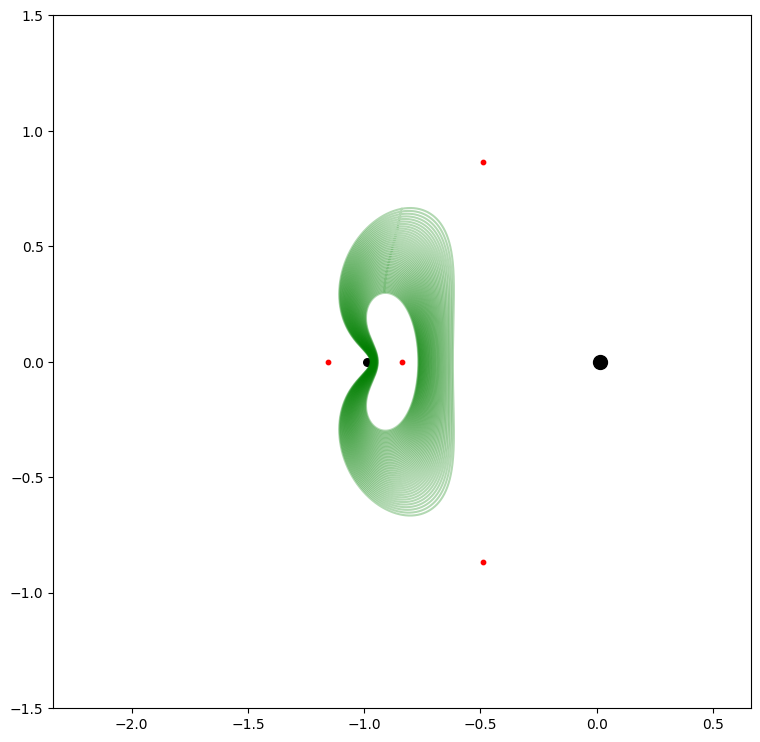

In [21]:
plt.figure(figsize=(9,9))

ax = plt.subplot(1,1,1)


# Plot the lagrangian points and primaries
zoom=1.5
ax.set_xlim(-xL1-zoom, -xL1+zoom)
ax.set_ylim(-zoom, +zoom)
ax.scatter(mu, 0, c='k', s=100)
ax.scatter(-(1-mu), 0, c='k', s=30)
ax.scatter(-xL1, 0, c='r', s=10)
ax.scatter(-xL2, 0, c='r', s=10)
ax.scatter(-xL3, 0, c='r', s=10)
ax.scatter(-xL4, yL4, c='r', s=10)
ax.scatter(-xL5, yL5, c='r', s=10)

#Set to true to get more info on the iterations
verbose = True
start_time = time.time()
# Main iterations
out = {}
for i in range(50):
    # We call the predictor
    predicted, taux, tauT = predictor_pa(ta, new_ic, new_period, ds)
    # We call the corrector, if it fails (A^tA goes singular) we decrease the pseudo arc-length and try again
    try:
        corrected_N, err = diff_corr_pa(ta, new_ic, new_period, ds, predicted[:,0], taux, tauT, tol=1e-15)
        # Log
        if verbose:
            print("ds:", ds, "err:", err)
        # Accept the step
        if err < 1e-12:
            new_ic = new_ic + corrected_N[:6]
            new_period = new_period + corrected_N[6]
            if verbose: 
                print("Converged - increase ds")
            ds*=1.2
            if ds >0.05:
                ds=0.05
            # Reset the state
            ta.time = 0
            ta.state[:] = new_ic.tolist() + ic_var
            # Time grid
            t_grid = np.linspace(0, new_period, 2000)
            # Propagate
            out[i] = ta.propagate_grid(t_grid)[5]
            # Plot
            ax.plot(out[i][:, 0], out[i][:, 1],'g', alpha=0.3)
        # Reject the step
        else:
            ds/=1.1
            if verbose:
                print("Low Precision - reducing ds")
    # The (A^T A) matrix was likely singular, we reduce the step ad try again.
    except:
        if verbose:
            print("Singular matrix - reducing ds")
        ds/=1.1
print("--- %s seconds --- to do the iterations" % (time.time() - start_time))

In [19]:
out[40][0:2000:100, :2]

array([[-0.8391969 ,  0.04975396],
       [-0.83445959,  0.04499425],
       [-0.83010999,  0.03597017],
       [-0.82675017,  0.02352834],
       [-0.82486715,  0.00883781],
       [-0.8247415 , -0.00670118],
       [-0.82639214, -0.02159662],
       [-0.82957251, -0.03442636],
       [-0.83381937, -0.04398263],
       [-0.8385403 , -0.0493706 ],
       [-0.84312148, -0.05005804],
       [-0.84704023, -0.04589681],
       [-0.849965  , -0.03714608],
       [-0.85180851, -0.02451657],
       [-0.85268176, -0.00921122],
       [-0.85273227,  0.00712957],
       [-0.85197156,  0.02266735],
       [-0.85026181,  0.03571882],
       [-0.84747636,  0.04501831],
       [-0.84367178,  0.04979327]])